# Clustering Stefano Boccaletti's collaboration network

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import xgi
from collections import defaultdict
from itertools import combinations
import pandas as pd

from hyperfunctions import *
from modularity_functions import *

##  Constructing the Hypergraph

We create the hypergraph with Stefano's coauthors and their respective coauthors.

In [5]:
df = pd.read_csv('Datasets/boccaletti_and_cocoauthors.csv', sep = ';')

hyperedge_dict = {}
for paper, ID in enumerate(df['Author(s) ID']):
    hyperedge_dict[paper] = ID.split(';')[:-1]

H = xgi.Hypergraph(hyperedge_dict)
print(len(H.edges), len(H.nodes))

15237 20227


We create the hypergraph with only Stefano's coauthors. We can apply some restrictions to the number of papers with him to be considered a coauthor.

In [6]:
restriction_papers = 6

In [16]:
dg = pd.read_csv('Datasets/boccaletti_coauthors.csv', sep = ',')

hyperedge_dic = {}
for paper, ID in enumerate(dg['Author(s) ID']):
    hyperedge_dic[paper] = ID.split(';')[:-1]

E = xgi.Hypergraph(hyperedge_dic)

print(len(E.edges), len(E.nodes))

for node in list(E.nodes):
    if E.degree(node) < restriction_papers:
        E.remove_node(node)     

print(len(E.edges), len(E.nodes))

338 414
338 62


*To do*: compute number of papers with stefano, remove nodes with less than a certain amount, remove Stefano

Keep from the first hypergraph (H) the nodes from the second hypergraph (E)

In [17]:
for node in list(H.nodes):
    if node in list(E.nodes):
        continue
    else:
        H.remove_node(node)

H.remove_edges_from(H.edges.singletons())

In [18]:
print(len(H.nodes), len(H.edges))

62 1651


In [19]:
nodes_list = list(H.nodes)

In [20]:
Authors_list = []
IDs_list = []
for author, ID in zip(dg['Authors'],dg['Author(s) ID']):
    Authors_list.append(author.split(', '))
    IDs_list.append(ID.split(';')[:-1])

authors_dict = {}
IDs_dict={}
for cont, authors in enumerate(Authors_list):
    for cont_2, author in enumerate(authors):
        IDs_dict[IDs_list[cont][cont_2]] = author
        authors_dict[author] = IDs_list[cont][cont_2]
        

## Communities

In [23]:
derivative = derivative_list(H)

In [24]:
method = "average"

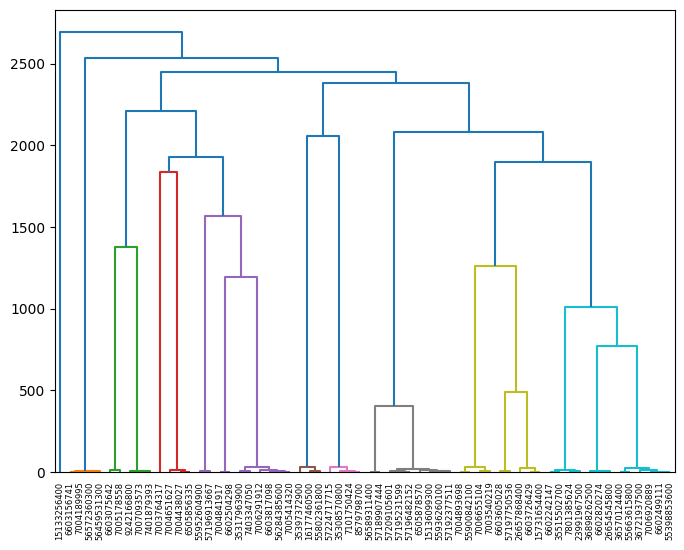

In [25]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

Z = hierarchy.linkage(derivative, method)
dn = hierarchy.dendrogram(Z, labels = nodes_list, orientation='top', count_sort='ascending', ax=ax)

plt.show()

## General (us)

In [33]:
h_cut, num_fusion = height_based_cut(Z)

In [34]:
Num_communities = len(set(Communities_dict.values()))
print(Num_communities)

19


In [35]:
communities_dict = communities(H, derivative, method, n_clusters=Num_communities)

nodeset_list = []
nodeset_list_names = []
for nodeset in communities_dict.values():
    nodeset_list.append(nodeset)
    nodeset_list_names.append([IDs_dict[ID] for ID in nodeset])
    print([IDs_dict[ID] for ID in nodeset])

    print("###")

['Zhang X.', 'Barzel B.', 'Havlin S.']
###
['Arecchi F.T.', 'Allaria E.', 'Kurths J.', 'Boccaletti S.', 'Meucci R.', 'Zhou C.S.']
###
['Mendoza C.', 'Bragard J.']
###
['Maza D.', 'Mancini H.']
###
['Residori S.', 'Ramazza P.L.', 'Bortolozzo U.']
###
['Li X.', 'Dai X.', 'Wang Z.', 'Guo H.', 'Perc M.', 'Jusup M.', 'Jia D.']
###
['Papo D.', 'Menasalvas E.', 'Sousa P.A.C.', 'Zanin M.']
###
['Makarov V.V.', 'Hramov A.E.', 'Maksimenko V.A.', 'Koronovskii A.A.']
###
['Alfaro-Bittner K.', 'Raigorodskii A.M.']
###
['Frasca M.', 'Moreno Y.', 'Latora V.', 'Gómez-Gardeñes J.']
###
['Criado R.', 'Romance M.', 'del Genio C.I.']
###
['Shen C.', 'Shi L.']
###
['Liu Z.', 'Qiu T.', 'Zou Y.', 'Guan S.']
###
['Gutiérrez R.', 'Sevilla-Escoboza R.', 'Buldú J.']
###
['Amann A.', 'Chavez M.', 'Hwang D.-U.']
###
['Soregaroli C.']
###
['Almendral J.A.', 'Sendiña-Nadal I.', 'del-Pozo F.', 'Bajo R.', 'Navas A.', 'Leyva I.']
###
['Pecora L.M.', 'Valladares D.L.']
###
['Giaquinta A.']
###


## Modularity (us)

In [37]:
A, G, mapping = reduced_adjacency_matrix(H)

In [38]:
Modularity = []
for n in range(len(H.nodes)):
    
    if n % 50 == 0:
        print(f'-- {n/len(H.nodes)}% --')
    
    cuttree = hierarchy.cut_tree(Z, n_clusters = n)
    Communities_dict = {}

    for cont, i in enumerate(nodes_list):
        Communities_dict[i] = cuttree[cont][0]

    # Get the list of communities
    grouped_dict = defaultdict(list)
    for key, val in Communities_dict.items():
        grouped_dict[val].append(key)

    Communities_list = list(grouped_dict.values())
        
    q = nx.community.modularity(G, Communities_list)
    
    Modularity.append(q)

-- 0.0% --
-- 0.8064516129032258% --


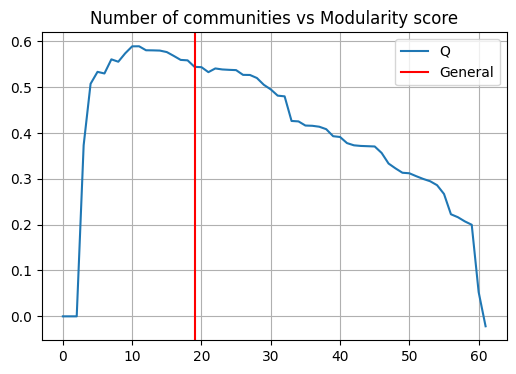

In [39]:
plt.figure(figsize=(6,4))
plt.title("Number of communities vs Modularity score")
plt.plot(range(len(H.nodes)), Modularity, label='Q')
plt.grid()
plt.axvline(Num_communities, color='r', label='General')

plt.legend()

*Conclusion*: the general method coincides with our modularity maximization in this example

In [40]:
m = max(Modularity)
num_fusion = [i for i, j in enumerate(Modularity) if j == m]
index_max = num_fusion[0]

print(f'Number of communities maximizing the modularity is: {index_max},')
print(f'with modularity: {m}')

Number of communities maximizing the modularity is: 11,
with modularity: 0.5890283126180561


In [41]:
communities_dict = communities(H, derivative, method, n_clusters=num_fusion)

nodeset_list = []
nodeset_list_names = []
for nodeset in communities_dict.values():
    nodeset_list.append(nodeset)
    nodeset_list_names.append([IDs_dict[ID] for ID in nodeset])
    print([IDs_dict[ID] for ID in nodeset])

    print("###")

['Zhang X.', 'Barzel B.', 'Havlin S.']
###
['Arecchi F.T.', 'Bragard J.', 'Allaria E.', 'Mancini H.', 'Kurths J.', 'Mendoza C.', 'Maza D.', 'Boccaletti S.', 'Meucci R.', 'Zhou C.S.']
###
['Residori S.', 'Ramazza P.L.', 'Bortolozzo U.']
###
['Li X.', 'Shen C.', 'Dai X.', 'Shi L.', 'Wang Z.', 'Guo H.', 'Perc M.', 'Jusup M.', 'Jia D.']
###
['Buldú J.', 'Almendral J.A.', 'Papo D.', 'Menasalvas E.', 'Sousa P.A.C.', 'Sendiña-Nadal I.', 'Sevilla-Escoboza R.', 'Bajo R.', 'del-Pozo F.', 'Gutiérrez R.', 'Zanin M.', 'Navas A.', 'Leyva I.']
###
['Makarov V.V.', 'Hramov A.E.', 'Maksimenko V.A.', 'Koronovskii A.A.']
###
['Latora V.', 'del Genio C.I.', 'Romance M.', 'Gómez-Gardeñes J.', 'Frasca M.', 'Alfaro-Bittner K.', 'Criado R.', 'Moreno Y.', 'Raigorodskii A.M.']
###
['Liu Z.', 'Qiu T.', 'Zou Y.', 'Guan S.']
###
['Hwang D.-U.', 'Amann A.', 'Chavez M.', 'Valladares D.L.', 'Pecora L.M.']
###
['Soregaroli C.']
###
['Giaquinta A.']
###


## Modularity (Kumar)

In [46]:
clusters = IRMM_algorithm(H, tol=1e-3)
Communities_K = []
for comm in clusters:
    Community_K = []
    for node in comm:
        Community_K.append(IDs_dict[mapping[node]])
    Communities_K.append(Community_K)
    print(Community_K)


q = nx.community.modularity(G,Communities_K)
print(f'The modularity for this partition is: {q}')

It converge after 27 iterations
['Hramov A.E.', 'Koronovskii A.A.', 'Maksimenko V.A.', 'Makarov V.V.']
['Dai X.', 'Jusup M.', 'Li X.', 'Guo H.', 'Jia D.', 'Wang Z.', 'Perc M.', 'Shi L.', 'Shen C.']
['Criado R.', 'Romance M.']
['Gómez-Gardeñes J.', 'Latora V.', 'Frasca M.', 'Moreno Y.', 'Chavez M.']
['Havlin S.', 'Zou Y.', 'Kurths J.', 'Liu Z.', 'Qiu T.', 'Zhang X.', 'Zhou C.S.', 'Guan S.']
['Ramazza P.L.', 'Bortolozzo U.', 'Residori S.']
['Meucci R.', 'Allaria E.', 'Giaquinta A.', 'Arecchi F.T.']
['Boccaletti S.', 'Bragard J.', 'Mancini H.', 'Menasalvas E.', 'Raigorodskii A.M.', 'Papo D.', 'del Genio C.I.', 'Alfaro-Bittner K.', 'Barzel B.', 'Zanin M.', 'Maza D.', 'Sousa P.A.C.', 'Buldú J.', 'Amann A.', 'Soregaroli C.', 'Mendoza C.', 'Sendiña-Nadal I.', 'Sevilla-Escoboza R.', 'Leyva I.', 'Bajo R.', 'del-Pozo F.', 'Gutiérrez R.', 'Valladares D.L.', 'Pecora L.M.', 'Almendral J.A.', 'Hwang D.-U.', 'Navas A.']


NotAPartition: [['Hramov A.E.', 'Koronovskii A.A.', 'Maksimenko V.A.', 'Makarov V.V.'], ['Dai X.', 'Jusup M.', 'Li X.', 'Guo H.', 'Jia D.', 'Wang Z.', 'Perc M.', 'Shi L.', 'Shen C.'], ['Criado R.', 'Romance M.'], ['Gómez-Gardeñes J.', 'Latora V.', 'Frasca M.', 'Moreno Y.', 'Chavez M.'], ['Havlin S.', 'Zou Y.', 'Kurths J.', 'Liu Z.', 'Qiu T.', 'Zhang X.', 'Zhou C.S.', 'Guan S.'], ['Ramazza P.L.', 'Bortolozzo U.', 'Residori S.'], ['Meucci R.', 'Allaria E.', 'Giaquinta A.', 'Arecchi F.T.'], ['Boccaletti S.', 'Bragard J.', 'Mancini H.', 'Menasalvas E.', 'Raigorodskii A.M.', 'Papo D.', 'del Genio C.I.', 'Alfaro-Bittner K.', 'Barzel B.', 'Zanin M.', 'Maza D.', 'Sousa P.A.C.', 'Buldú J.', 'Amann A.', 'Soregaroli C.', 'Mendoza C.', 'Sendiña-Nadal I.', 'Sevilla-Escoboza R.', 'Leyva I.', 'Bajo R.', 'del-Pozo F.', 'Gutiérrez R.', 'Valladares D.L.', 'Pecora L.M.', 'Almendral J.A.', 'Hwang D.-U.', 'Navas A.']] is not a valid partition of the graph Graph with 62 nodes and 418 edges

## Modularity (Kaminski)